# Airplane Wildlife Dataset EDA
## By James Zhang and Vijaykaarti Sundarapandiyan

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn

## Data Preprocessing

Before any machine learning models or statistical tests, let us first get a feel for our dataset by conducting some basic data preprocessing, which includes identifying useful characteristics and converting features to appropriate types.

In [46]:
df = pd.read_csv("data.csv")
# Immediately drop duplicates, if there are any.
df = df.drop_duplicates()
# Additionally, we know will be working with the the TIME_OF_DAY, TIME, SIZE columns, so drop rows without all three of these values
df = df.dropna(subset=["TIME", "TIME_OF_DAY", "SIZE"])
# display a quick preview of our dataset
display(df.head())
f'There are {df.shape[0]} rows and {df.shape[1]} columns'

/var/folders/qr/7xvxlvfj457dcq7g11qpp63w0000gn/T/ipykernel_15037/3212728515.py:1: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
10,608253,8/7/1990,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,Large,NaN,NaN,OPER = DOUG HANN (3/1/12 UPDATED ID) /Legacy R...,REDACTED,REDACTED,FAA Form 5200-7,NaN,3/1/2012,False
45,608290,8/5/1990,8,1990,19:05,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.17540,-76.66820,...,Small,NaN,NaN,/Legacy Record=100049/,REDACTED,REDACTED,FAA Form 5200-7,NaN,2/10/1999,False
64,608314,10/31/1990,10,1990,08:08,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.69250,-74.16866,...,Medium,NaN,NaN,A/C REG REPTD AS N744 INCORRECT /Legacy Record...,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/18/1998,False
122,608388,4/17/1991,4,1991,13:15,Day,KDCA,RONALD REAGAN WASHINGTON NATIONAL ARPT,38.85208,-77.03772,...,Medium,NaN,NaN,/Legacy Record=100147/,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/19/2003,False
136,608407,10/15/1990,10,1990,10:07,Night,KTRI,TRI-CITIES REGIONAL TN/VA ARPT,36.47521,-82.40742,...,Medium,NaN,NaN,/Legacy Record=100166/,REDACTED,REDACTED,FAA Form 5200-7,NaN,12/4/1998,False


'There are 112209 rows and 100 columns'

Our dataset has $288, 810$ rows/entries and $100$ columns/features. $100$ features gives us lots of options to choose from when it comes to feature selection, machine learning models, regressions, and hypothesis tests. To get more information about each feature, we can use `df.info()` to find out some basic information like the Non-Null Count and datatype.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112209 entries, 10 to 288808
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INDEX_NR               112209 non-null  int64  
 1   INCIDENT_DATE          112209 non-null  object 
 2   INCIDENT_MONTH         112209 non-null  int64  
 3   INCIDENT_YEAR          112209 non-null  int64  
 4   TIME                   112209 non-null  object 
 5   TIME_OF_DAY            112209 non-null  object 
 6   AIRPORT_ID             112208 non-null  object 
 7   AIRPORT                112209 non-null  object 
 8   LATITUDE               107376 non-null  float64
 9   LONGITUDE              107375 non-null  float64
 10  RUNWAY                 98432 non-null   object 
 11  STATE                  107376 non-null  object 
 12  FAAREGION              107376 non-null  object 
 13  LOCATION               4516 non-null    object 
 14  ENROUTE_STATE          3093 non-null   

On a high level, our features can be categorized in the following manner:
- Time `(INCIDENT_DATE, TIME, TIME_OF_DAY)`
- Metadata `(SOURCE, INDEX_NR, AIRPORT)`
- Physics-related `(AC_MASS, HEIGHT, SPEED, DISTANCE)`
- Species-related `(SPECIES, SPECIES_ID, REMAINS_COLLECTED, NR_INJURIES)`
- Money-related `(COST_REPAIRS, COST_REPAIRS_INFL_ADJ, COST_OTHER)`
- Categorical `(WARNED, SKY, AIRCRAFT)`
- Boolean `(DAM_RAD, DAM_WINDSHIELD, STR_ENG1)`

Once more, there is more than sufficent data collected in this dataset. Furthermore, the owners of the dataset have done a pretty good job of converting columns to the appropriate datatypes, ie. to float and string when needed. The only additional needed preprocessing is with respect to the time-related columns. Conversion for the `INCIDENT_DATE` column to `pd.datetime` is trivial. The `TIME` column required a little bit more effort, however. There were some errors in the data such as NaN values and minute recordings between greater than $60$, which doesn't make sense. See our implementation below. 

In [48]:
def time_helper(x):
    # If nan, then just return nan.
    if isinstance(x, float):
        return np.NaN
    # We want at least hour and minute precision.
    elements = str(x).split(':')
    if len(elements) < 2:
        return np.NaN
    # Ensure validity of hours and minutes before returning.
    h, m = int(elements[0]), int(elements[1])
    return x if h in range(0, 25) and m in range(0, 61) else np.NaN

df["TIME"] = df["TIME"].apply(time_helper)
df = df.dropna(subset=["TIME"])
df["TIME"] = pd.to_datetime(df["TIME"], format="%H:%M", errors="coerce")
df = df.dropna(subset=["TIME"])

#preview
df

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
10,608253,8/7/1990,8,1990,1900-01-01 20:25:00,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,Large,NaN,NaN,OPER = DOUG HANN (3/1/12 UPDATED ID) /Legacy R...,REDACTED,REDACTED,FAA Form 5200-7,NaN,3/1/2012,False
45,608290,8/5/1990,8,1990,1900-01-01 19:05:00,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.17540,-76.66820,...,Small,NaN,NaN,/Legacy Record=100049/,REDACTED,REDACTED,FAA Form 5200-7,NaN,2/10/1999,False
64,608314,10/31/1990,10,1990,1900-01-01 08:08:00,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.69250,-74.16866,...,Medium,NaN,NaN,A/C REG REPTD AS N744 INCORRECT /Legacy Record...,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/18/1998,False
122,608388,4/17/1991,4,1991,1900-01-01 13:15:00,Day,KDCA,RONALD REAGAN WASHINGTON NATIONAL ARPT,38.85208,-77.03772,...,Medium,NaN,NaN,/Legacy Record=100147/,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/19/2003,False
136,608407,10/15/1990,10,1990,1900-01-01 10:07:00,Night,KTRI,TRI-CITIES REGIONAL TN/VA ARPT,36.47521,-82.40742,...,Medium,NaN,NaN,/Legacy Record=100166/,REDACTED,REDACTED,FAA Form 5200-7,NaN,12/4/1998,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288795,1472236,8/28/2023,8,2023,1900-01-01 23:20:00,Night,KRSW,SOUTHWEST FLORIDA INTL ARPT,26.53617,-81.75517,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288798,1472241,8/28/2023,8,2023,1900-01-01 11:25:00,Night,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,11/17/2023,False
288804,1472251,8/28/2023,8,2023,1900-01-01 23:00:00,Night,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,11/17/2023,False
288807,1472257,8/28/2023,8,2023,1900-01-01 07:14:00,Dusk,KDTW,DETROIT METRO WAYNE COUNTY ARPT,42.21206,-83.34884,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


## Basic Data Exploration and Summary Statistics

We can also print out some summary statistics for each of our numerical columns using the `df.describe()` method. Note that some of these entries are meaningless; for example, the standard deviation of the Latitude column holds no weight. On the other hand, some entries such as the mean speed of the airplane can be useful for later analysis, but this representation is overall pleasant and informational. 

In [49]:
df.describe()

,INDEX_NR,INCIDENT_MONTH,INCIDENT_YEAR,TIME,LATITUDE,LONGITUDE,EMA,EMO,AC_MASS,NUM_ENGS,...,ENG_2_POS,ENG_3_POS,ENG_4_POS,HEIGHT,SPEED,DISTANCE,AOS,BIRD_BAND_NUMBER,NR_INJURIES,NR_FATALITIES
count,1.120200e+05,112020.000000,112020.000000,112020,1.071930e+05,107192.000000,102248.000000,99344.000000,109718.000000,109573.000000,...,100861.000000,6214.000000,1279.000000,96189.000000,62174.000000,73452.000000,9395.000000,1.330000e+02,170.000000,17.000000
mean,8.784088e+05,7.210909,2012.797358,1900-01-01 13:43:56.228709120,4.252592e+02,-89.575588,19.023707,8.074177,3.488489,1.995939,...,2.761841,2.534438,2.433933,803.796141,141.359443,1.400340,94.398225,7.017296e+07,1.317647,2.352941
min,6.082530e+05,1.000000,1990.000000,1900-01-01 00:00:00,-3.483842e+01,-177.381000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,7.033778e+05,5.000000,2008.000000,1900-01-01 09:00:00,3.336996e+01,-98.469780,10.000000,1.000000,3.000000,2.000000,...,1.000000,1.000000,1.000000,0.000000,120.000000,0.000000,1.000000,0.000000e+00,1.000000,1.000000
50%,7.638295e+05,8.000000,2014.000000,1900-01-01 13:22:00,3.869542e+01,-87.896580,22.000000,4.000000,4.000000,2.000000,...,1.000000,1.000000,1.000000,30.000000,139.000000,0.000000,3.000000,0.000000e+00,1.000000,2.000000
75%,1.063895e+06,9.000000,2018.000000,1900-01-01 19:00:00,4.078839e+01,-80.290560,23.000000,10.000000,4.000000,2.000000,...,5.000000,5.000000,4.000000,800.000000,160.000000,0.000000,24.000000,1.807804e+08,1.000000,3.000000
max,1.472258e+06,12.000000,2023.000000,1900-01-01 23:59:00,4.115443e+07,164140.000000,92.000000,2301.000000,5.000000,4.000000,...,7.000000,6.000000,5.000000,30000.000000,1250.000000,99.000000,10080.000000,2.811782e+08,7.000000,8.000000
std,2.479049e+05,2.763267,6.570082,NaN,1.257083e+05,502.331572,10.587937,13.354216,0.889417,0.405165,...,1.998701,1.882520,1.499652,1729.502656,46.108955,4.489294,420.063573,8.849556e+07,0.772482,1.868863


## Data Exploration / Summary Statistic Methods

Now, we'll move on to exploring actual features of the data, since now we've cleaned the data (at least, the relevant columns), with three statistical analyses themselves each accompanied by three graphs.

In [50]:
print(df["TIME"])

10       1900-01-01 20:25:00
45       1900-01-01 19:05:00
64       1900-01-01 08:08:00
122      1900-01-01 13:15:00
136      1900-01-01 10:07:00
                 ...        
288795   1900-01-01 23:20:00
288798   1900-01-01 11:25:00
288804   1900-01-01 23:00:00
288807   1900-01-01 07:14:00
288808   1900-01-01 09:00:00
Name: TIME, Length: 112020, dtype: datetime64[ns]


# Method #1: Exploring Time Distribution

Here, we'll convert the Time column into a numerical format and observe summary statistics for these values, and we'll plot the results in a boxplot



KeyError: "None of [Index(['Hour'], dtype='object')] are in the [columns]"

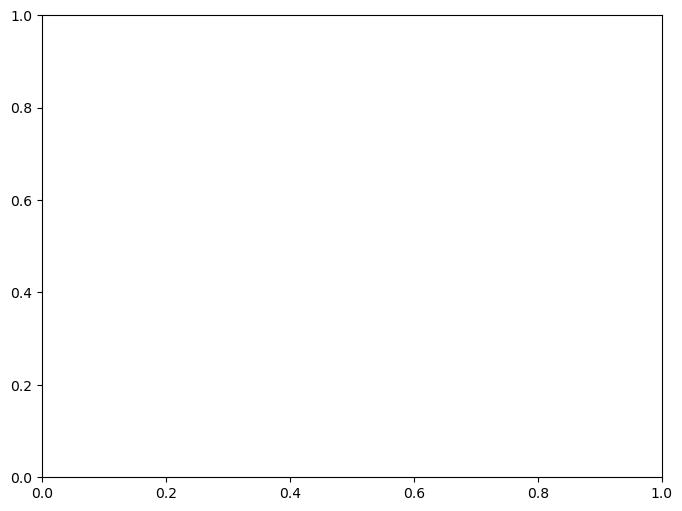

In [51]:
df["HOUR"] = df["TIME"].dt.hour
summary_stats = df["HOUR"].describe()

plt.figure(figsize = (8, 6))
df.boxplot(column = "Hour")
plt.title("Accident Occurences by Hour")
plt.ylabel("Hour")
plt.grid(False)
plt.show()

Analyzing the sideways box plot of accident occurrences by hour, we can extract a few important bits of information. First, there are no outliers, which makes sense because flights and therefore accidents can occur at any hour of the day. The whiskers extend to show the full range of data, with the left whisker being at $0 (12am)$ and the right whisker being at $23$ $(11pm)$ as desired. There exists a slight rightwards skew in the data. Most airplane wildlife crashes occur between the early morning and mid to late afternoon (dusk), which is interesting, but one important thing to note is that these are wildlife crashes. One might hypothesize that planes are most likely to crash when it is dark, however most animals are not flying that high in the sky in the dark, which could explain this distribution in the data, but more tests and information will need to be collected in order to back this hypothesis.

# Method #2: Testing the Effect of Time of Day and the Number of Accidents.

Here, we'll see if there is any relation between the time of day and the number of accidents occuring. We will perform a chi-square hypothesis test based on the actual frequency of different time of day accidents and the expected frequency of the accidents based on the size of the data set.

H0: The time of day has no effect on the probability of an accident occuring
HA: The time of day has an effect on the probability of an accident occuring


Chi-square statistic: 81004.53064241886
P-value: 0.0
Reject null hypothesis: Time of day and number of accidents are dependent


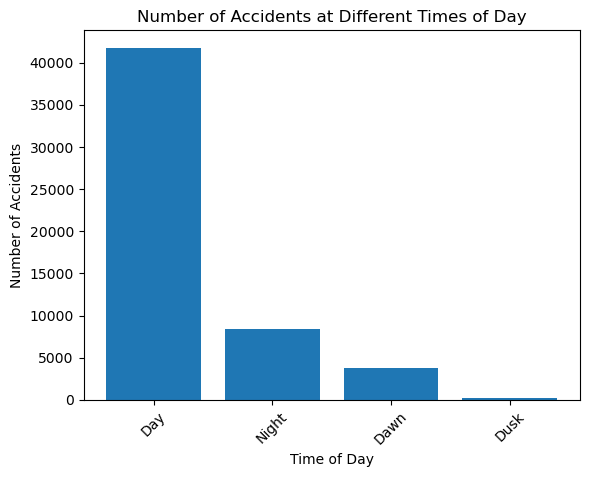

In [ ]:
import scipy.stats as stats

observed_frequencies = df["TIME_OF_DAY"].value_counts()
expected_frequences = len(df) / len(observed_frequencies)

# Step 4: Perform chi-square test
chi2, p_value = stats.chisquare(observed_frequence, expected)

# Step 5: Interpret results
alpha = 0.05
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject null hypothesis: Time of day and number of accidents are dependent")
else:
    print("Fail to reject null hypothesis: Time of day and number of accidents are independent")

# Step 6: Visualize results
plt.bar(observed.index, observed)
plt.xlabel('Time of Day')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents at Different Times of Day')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

